# Modules

In [116]:
import geopandas as gpd
import shapely
import pandas as pd
from math import pi,cos,radians
import pyproj
from shapely.ops import cascaded_union
from shapely.geometry import Point
%matplotlib inline

# Paths

In [86]:
lp_p = 'C:\\Users\\jlandman\\Desktop\\LeBris_Paul\\ElevationChange_GlaciersSupp1km2_LessThan20%DataVoid.shp' # LeBris/Paul shape
foga_p = 'C:\\Users\\jlandman\\Desktop\\DOI-WGMS-FoG-2015-11\\WGMS-FoG-2015-11-A-GENERAL-INFORMATION.csv'

# Read files

In [108]:
lp = gpd.read_file(lp_p)
foga = pd.read_csv(foga_p, encoding='iso-8859-1')

# Make an empty FoG-D DataFrame and create new FoG IDs

In [ ]:
fogd_templ = pd.DataFrame([], [['POLITICAL_UNIT', 'GLACIER_NAME', 'WGMS_ID', 'YEAR', 'LOWER_BOUND', 'UPPER_BOUND', 
                                'AREA_SURVEY_YEAR', 'AREA_CHANGE', 'AREA_CHANGE_UNCERTAINTY', 'THICKNESS_CHANGE', 
                                'THICKNESS_CHANGE_UNCERTAINTY', 'VOLUME_CHANGE', 'VOLUME_CHANGE_UNCERTAINTY', 'SURVEY_DATE',
                                'SURVEY_DATE_PLATFORM_METHOD', 'REFERENCE_DATE', 'REFERENCE_DATE_PLATFORM_METHOD',
                                'INVESTIGATOR', 'SPONSORING_AGENCY', 'REFERENCE', 'REMARKS']])

In [ ]:
new_ids = range(10000, 11000, 1)

# Determine uncertainty for given FoG coordinate

In [89]:
def coord_unc(x,y):
    """ Determine the uncertainity in meters for a given FoG coordinate at its lat/lon
    
    Parameters
    -----------
    x: longitude in degrees
    y: latitude in degrees
    
    Returns
    --------
    dx, dy: uncertainty in meters
    """
    # number of decimals given
    xd = len(str(x).split('.')[-1])
    yd = len(str(y).split('.')[-1])
    
    # maximum error in degrees
    xe = 10**(-xd)
    ye = 10**(-yd)
    
    # maximum error in meters
    dy = ye * ((2* pi * 6378000) / 360.)
    dx = xe * (2 * pi * cos(radians(y)) * 6378000) / 360.
    
    return dx, dy

In [128]:
def transform_coords(x,y,in_proj=None,out_proj=None):
    
    assert in_proj is not None,'Input projection may not be None.'
    assert out_proj is not None,'Output projection may not be None.'
    from_proj = pyproj.Proj(init='epsg:'+str(in_proj))
    to_proj = pyproj.Proj(init='epsg:'+str(out_proj))
    
    #x1, y1 = from_proj(x,y)
    return pyproj.transform(from_proj, to_proj, x,y)

# Build a buffer around all FoG points in the area, determined by the uncertainty of the coordinates

#### We define the two Projs we are dealing with

In [90]:
utm7n = pyproj.Proj(init='epsg:32605') # WGS84 UTM 5N -> LeBris/Paul
latlon = pyproj.Proj(init='epsg:4326') # WGS84 lat/lon -> FoG

#### Select the FoG points with the extent rectangle by LeBris/Paul

In [91]:
lp_extent = lp.total_bounds

In [104]:
# convert UTM5N to WGS84 lat/lon points
x_lp = [lp_extent[0], lp_extent[2]]
y_lp = [lp_extent[1], lp_extent[3]]
x1,y1 = utm7n(x_lp, y_lp)
x_lpll, y_lpll = pyproj.transform(utm7n,latlon,x_lp,y_lp)

In [109]:
foga = foga[(foga.LONGITUDE >= x_lpll[0]) & (foga.LONGITUDE <= x_lpll[1]) & (foga.LATITUDE >= y_lpll[0]) & (foga.LATITUDE <= y_lpll[1])]

In [166]:
len(foga)

97

#### Create a buffer around them, determined by the uncertainty of the coordinates

In [114]:
# convert WGS84 lat/lon points to UTM5N
xs = foga.LONGITUDE.values
ys = foga.LATITUDE.values
x1,y1 = latlon(xs, ys)
xm, ym = pyproj.transform(latlon,utm7n,xs,ys)

In [123]:
buffers = [Point(x,y).buffer(coord_unc(transform_coords(x,y,32605,4326)[0],transform_coords(x,y,32605,4326)[1])[1]) for x,y in zip(xm,ym)]

In [125]:
# make the buffer one geometry
buffer_union = cascaded_union(buffers)

In [ ]:
# create a series of true/false of those that do not intersect with the buffer should be tried to be directly imported into FoG (there WILL be mistakes) !!!
disjoint = lp.disjoint(buffer_union)

In [150]:
disjoint_ix = disjoint[disjoint == True].index
intersect_ix = disjoint[disjoint == False].index

In [151]:
disjoint_ix
intersect_ix

Int64Index([ 33,  42,  98,  99, 100, 101, 102, 103, 107, 177, 179, 181, 182,
            184, 185, 192, 193, 195, 203, 204, 205, 279, 280, 281, 282, 283,
            284, 285, 287, 288, 289, 290, 291, 292, 293, 294, 296, 298, 311,
            312, 360, 364, 409, 769, 774, 777, 781, 792, 928, 971, 973, 974,
            975, 976, 978, 979, 980],
           dtype='int64')

In [156]:
# get the real geometries
fast_to_FoG = lp[lp.index.isin(disjoint_ix)]
check_closely = lp[lp.index.isin(intersect_ix)]

In [157]:
assert len(fast_to_FoG)+len(check_closely)==len(lp)

In [165]:
len(fast_to_FoG)

927

In [159]:
fast_to_FoG.head()

,AREA,ID,Mean_Slope,Type,abla_max,abla_mean,abla_min,accu_max,accu_mean,accu_min,data_void,dh_mean,distance,geometry,glacier_na,mean_elev
0,1.00926,0,11.463373,0,0.529638,0.019576,-0.539426,0.438751,0.044650,-0.225459,9.002639,0.031097,374904.390260,"POLYGON ((740432.9619000014 6926141.278299998,...",None,1937.799683
1,1.99968,1,10.652687,0,0.004134,-0.550919,-1.093450,0.214114,-0.675848,-1.267480,5.904943,-0.604927,364756.600625,"POLYGON ((747786.5420999993 6916886.153700002,...",None,1817.373535
2,1.43473,2,16.190556,0,0.075697,-0.669518,-1.507220,0.552516,-0.281408,-2.415110,7.550550,-0.495616,363653.089888,"POLYGON ((747510.9727267754 6915202.23442327, ...",None,1942.772827
3,2.06987,3,13.377052,0,0.176559,-0.357873,-1.367650,-0.281090,-0.894616,-2.092300,6.158355,-0.608700,357748.823628,"POLYGON ((732351.8668999996 6909953.610499999,...",None,1720.839233
4,2.65875,4,12.931275,0,0.171183,-0.681856,-1.759410,0.290771,-0.186491,-0.874991,4.075226,-0.459360,356117.889709,"POLYGON ((713898.410719209 6904324.999814478, ...",None,1804.301025


TypeError: float() argument must be a string or a number, not 'Polygon'

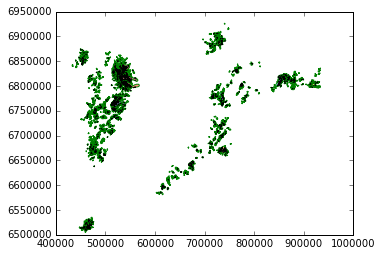

In [163]:
p = fast_to_FoG.plot(c='g')
p.plot(check_closely, c='r')

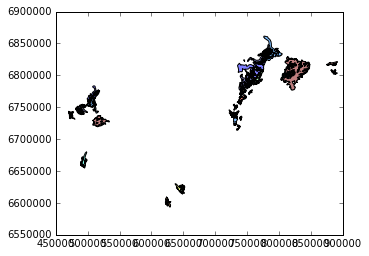

In [161]:
check_closely.plot()